Dimensões da imagem: (224, 224, 3)


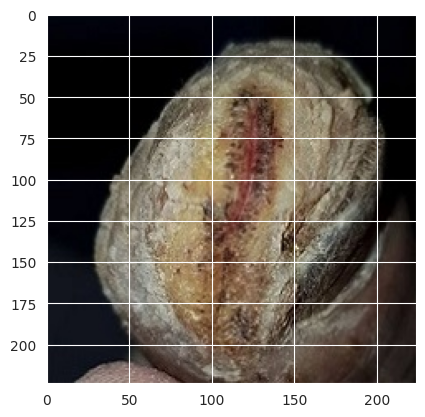

Tamanho do treino: 844, Validação: 105, Teste: 106
Contagem de classes após o corte: [410, 410]
Total de imagens aumentadas criadas: 0
Contagem final de classes no treino: [410, 410]
Found 820 validated image filenames belonging to 2 classes.
Found 106 validated image filenames belonging to 2 classes.
Found 105 validated image filenames belonging to 2 classes.


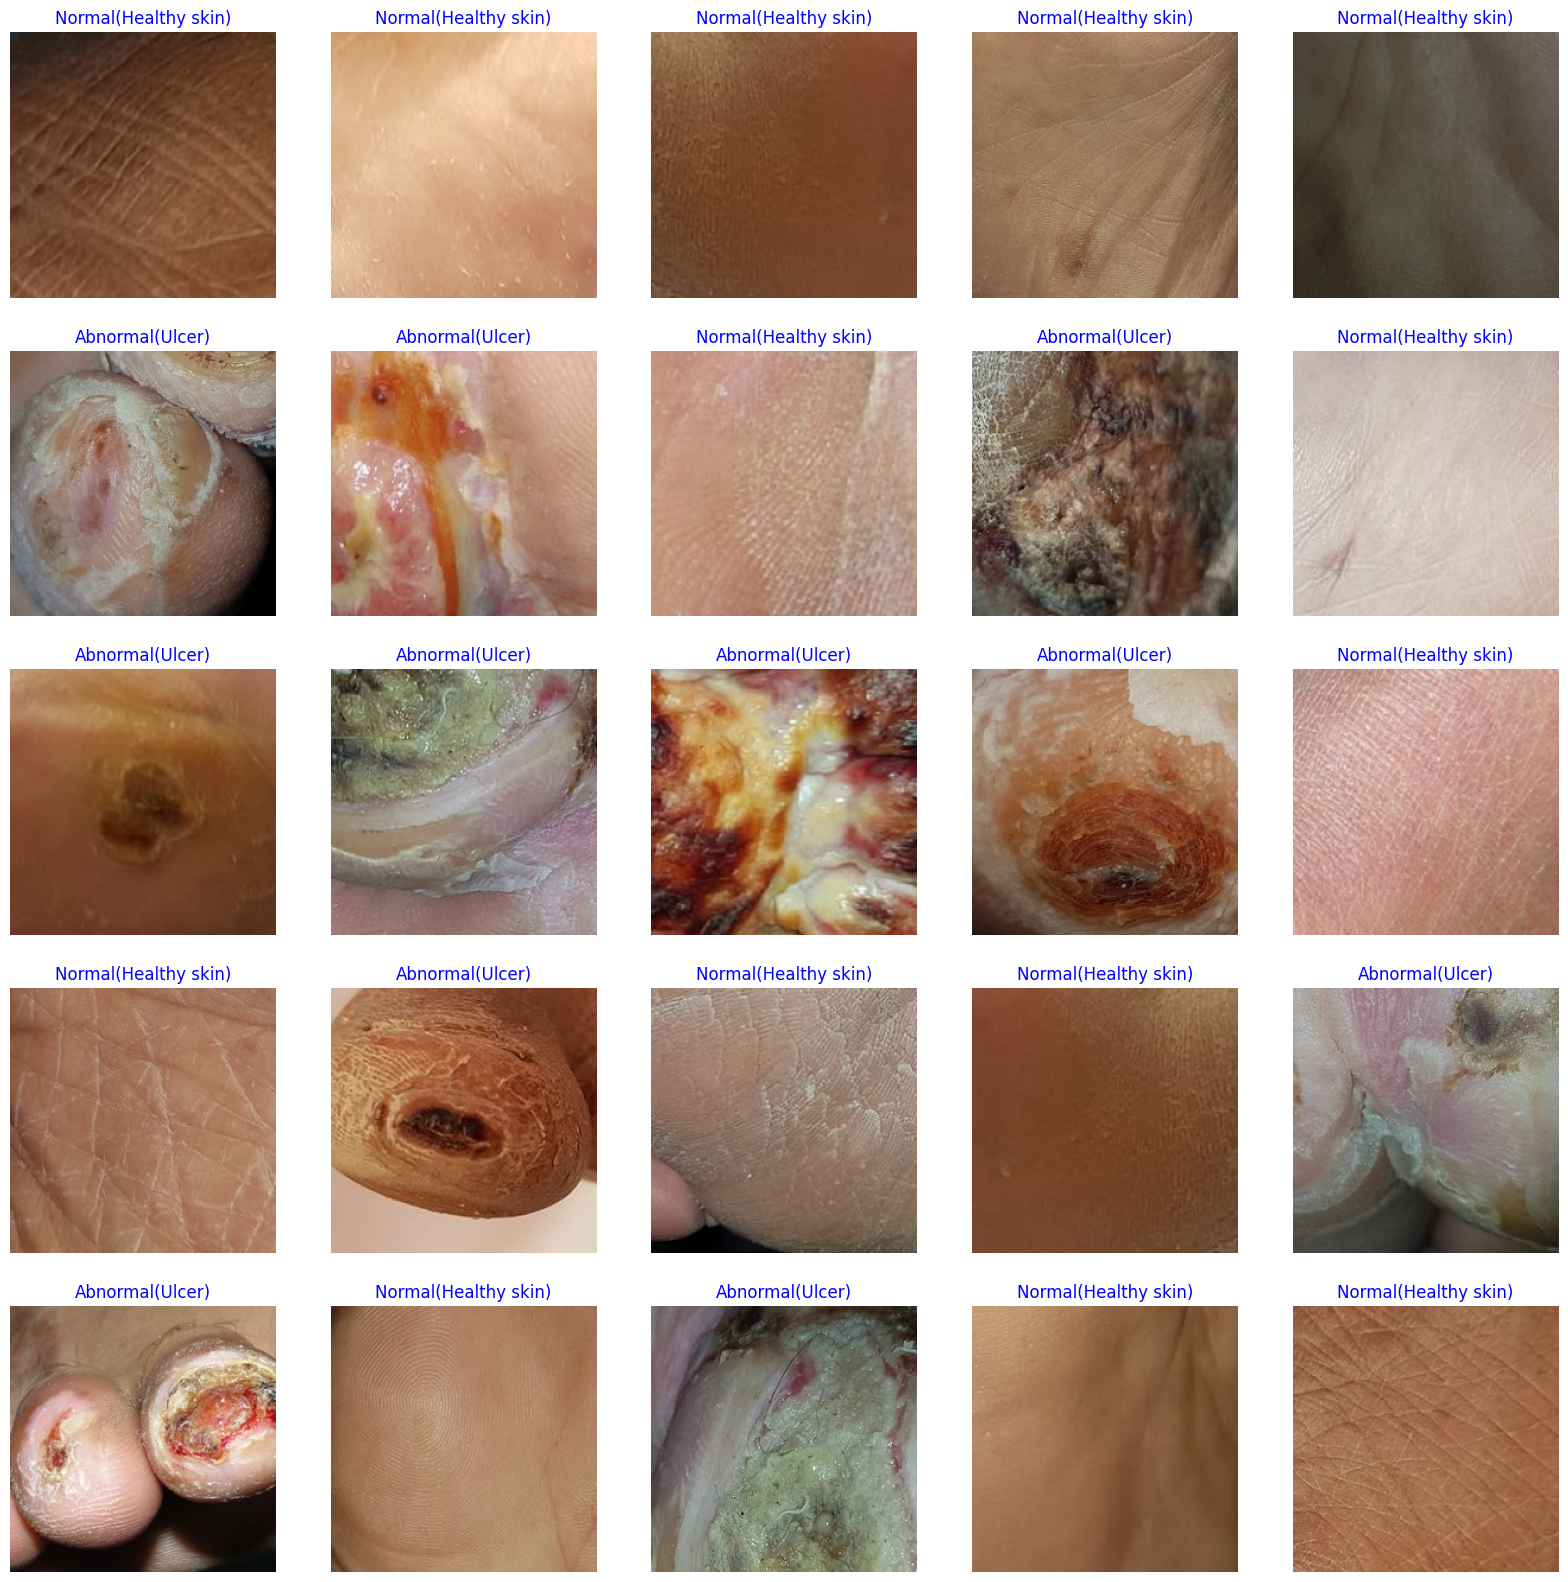

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Iniciando callback com modelo base não treinável.

 Época    Perda   Acurácia   P_Val    A_Val   Tx Apr   Próx Tx  Métrica  % Melhora Duração 

   1    / 40    4.127    94.39  %  3.65735   99.05  %  0.00100  0.00100   val_loss     0.00   %  165.14 s

   2    / 40    3.452    97.44  %  3.14704  100.00  %  0.00100  0.00100   val_loss    13.95   %  126.76 s

   3    / 40    3.003    98.78  %  2.80055  100.00  %  0.00100  0.00100   val_loss    11.01   %  115.88 s

   4    / 40    2.702    98.41  %  2.53293   99.05  %  0.00100  0.00100   val_loss     9.56   %  132.12 s

   5    / 40    2.443    98.66  %  2.31105   99.05  %  0.00100  0.00100   val_loss     8.76   %  138.93 s

   6    / 40    2.235    99.02  %  2.11511   99.05  %  0.00100  0.00100   val_loss     8.48   %  144.99 s

   7    / 40    2.038    99.39  %  1.94740   99.05  %  0.00100  0.00100   val_loss     7.93   %  114.01 s

   8    / 40    1.878    99.63  %  1.80066   99.05  %  0.00100  0.00100   val_loss     7.53   %  134.09 s



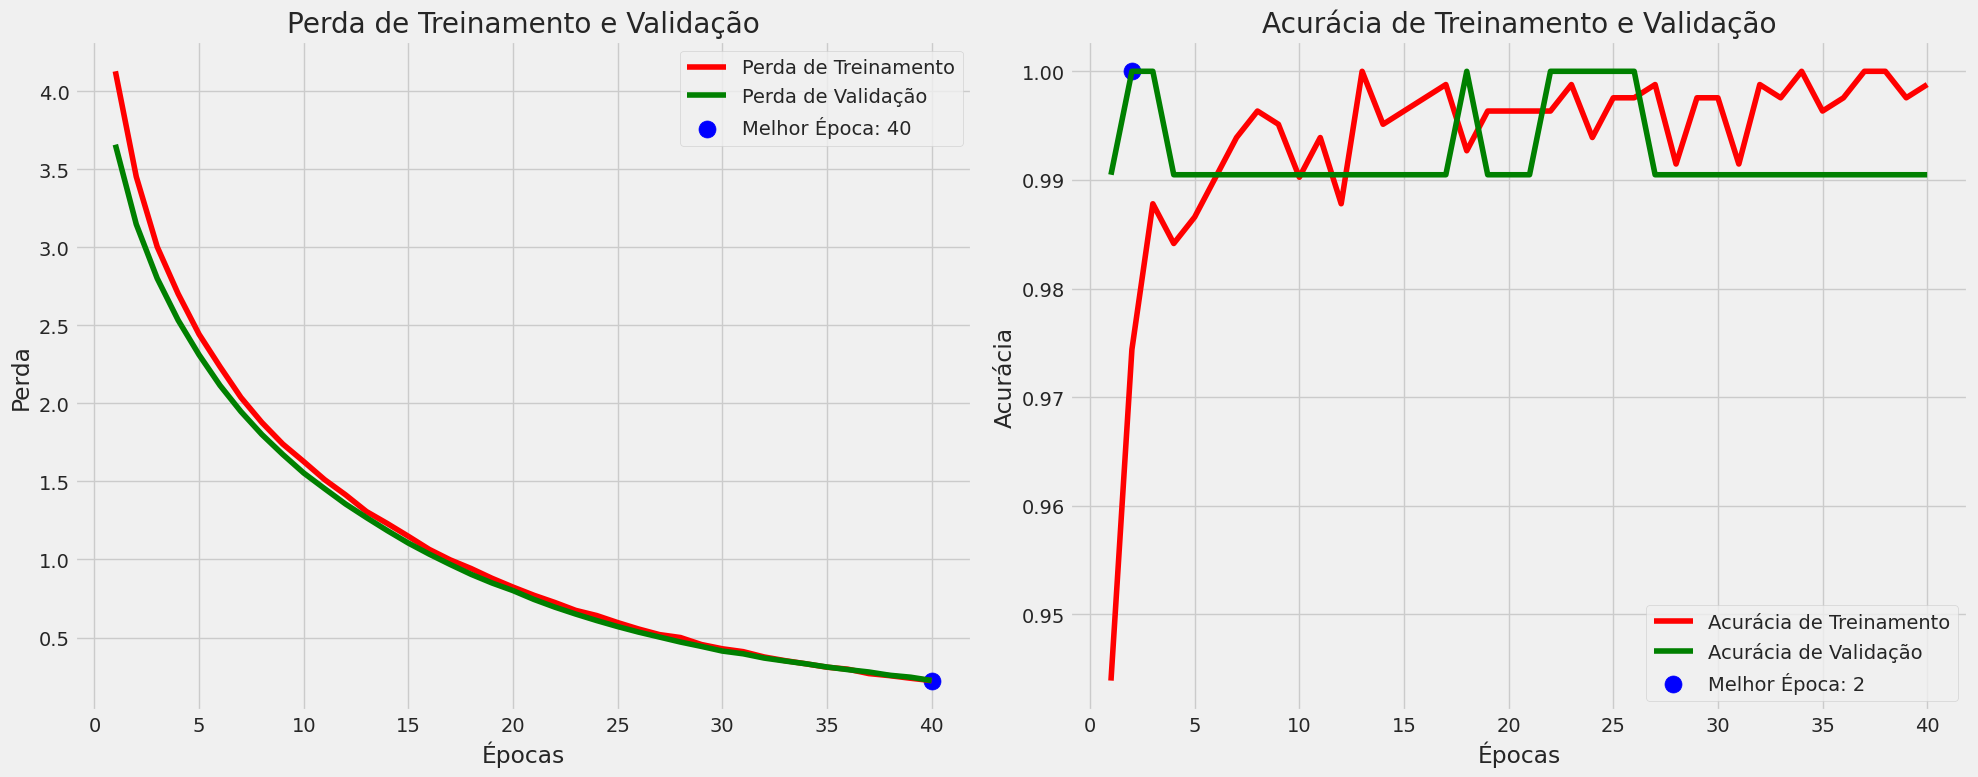

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


          Arquivo                  Classe Predita               Classe Real          Probabilidade  

  Abnormal(Ulcer)/232.jpg       Normal(Healthy skin)          Abnormal(Ulcer)            0.9997     



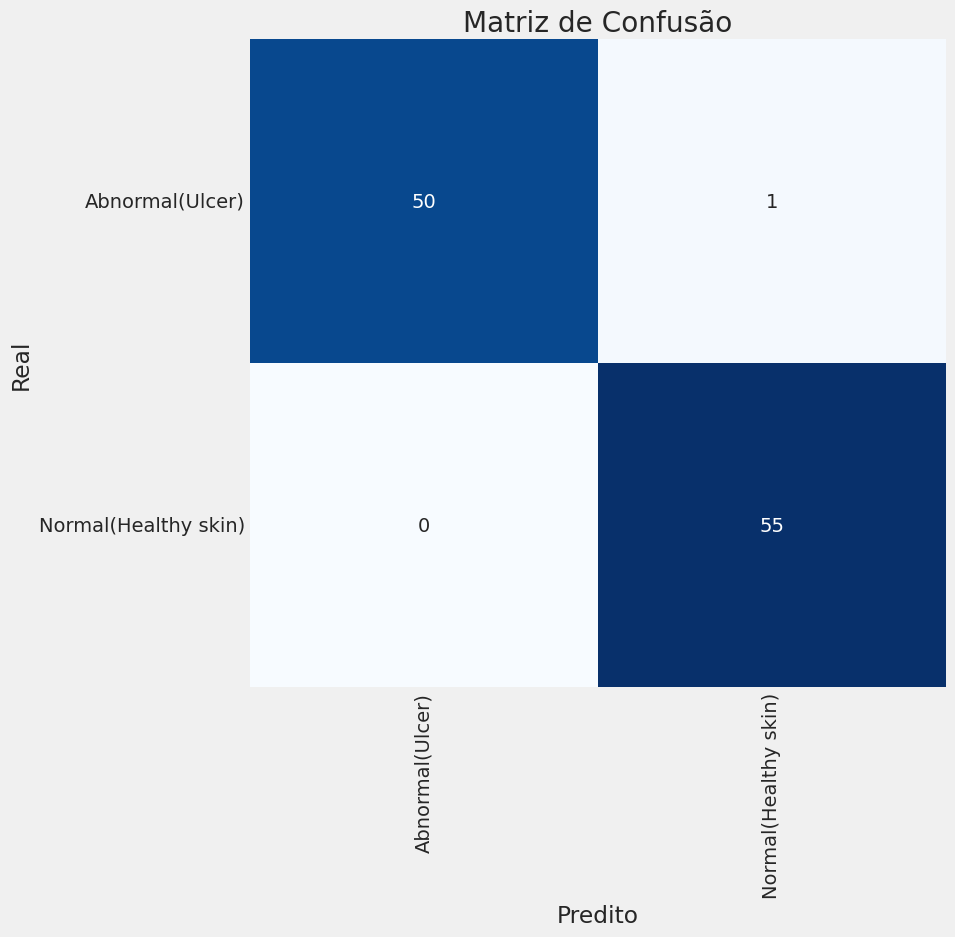

Relatório de Classificação:
----------------------
                       precision    recall  f1-score   support

     Abnormal(Ulcer)       1.00      0.98      0.99        51
Normal(Healthy skin)       0.98      1.00      0.99        55

            accuracy                           0.99       106
           macro avg       0.99      0.99      0.99       106
        weighted avg       0.99      0.99      0.99       106

Modelo salvo em: ../EfficientNetB2-DFU_Analysis-0.99.h5

Arquivo de classes salvo em: ../mapeamento_classes.csv



In [ ]:
# -*- coding: utf-8 -*-

# Importações de bibliotecas necessárias para o projeto.
# TensorFlow e Keras são usados para construir e treinar o modelo de aprendizado de máquina.
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend as K, models, layers, regularizers
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

# NumPy e Pandas para manipulação de dados.
import numpy as np
import pandas as pd

# Módulos do sistema para interagir com o sistema operacional.
import shutil
import time
import os

# OpenCV para processamento de imagem.
import cv2 as cv

# tqdm para barras de progresso.
from tqdm import tqdm

# Scikit-learn para divisão de dados e métricas de avaliação.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Matplotlib e Seaborn para visualização de dados.
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')

# Pillow para manipulação de imagens.
from PIL import Image

# IPython para exibição no notebook.
from IPython.display import display, HTML

# Configuração para suprimir mensagens de aviso do TensorFlow.
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


class EstilizadorDeTextoGrafico:
    """
    Esta classe é responsável por customizar a aparência de textos e gráficos
    exibidos no console, permitindo o uso de cores personalizadas.
    """

    def exibir_texto_colorido(self, mensagem, cor_frente, cor_fundo):
        """
        Imprime uma mensagem com cores de primeiro plano e de fundo específicas.

        Args:
            mensagem (str): O texto a ser exibido.
            cor_frente (tuple): Tupla (R, G, B) para a cor do texto.
            cor_fundo (tuple): Tupla (R, G, B) para a cor de fundo.
        """
        # Desempacota as tuplas de cores.
        r_frente, g_frente, b_frente = cor_frente
        r_fundo, g_fundo, b_fundo = cor_fundo

        # Formata a string de escape ANSI para definir as cores.
        string_formatada = f'\33[38;2;{r_frente};{g_frente};{b_frente};48;2;{r_fundo};{g_fundo};{b_fundo}m{mensagem}'

        # Imprime a mensagem colorida.
        print(string_formatada, flush=True)

        # Restaura a cor padrão do terminal.
        print('\33[0m', flush=True)


class AjustadorDinamicoTaxaAprendizagem(keras.callbacks.Callback):
    """
    Callback do Keras para ajustar dinamicamente a taxa de aprendizagem
    durante o treinamento, com base na performance do modelo.
    """

    def __init__(self, modelo_base, paciencia, paciencia_parada, limiar_acuracia,
                 fator_reducao, manter_pesos, lotes_total, epoca_inicial, epocas_total, epoca_interrupcao):
        super(AjustadorDinamicoTaxaAprendizagem, self).__init__()
        self.modelo_base = modelo_base
        self.paciencia = paciencia
        self.paciencia_parada = paciencia_parada
        self.limiar_acuracia = limiar_acuracia
        self.fator_reducao = fator_reducao
        self.manter_pesos = manter_pesos
        self.lotes_total = lotes_total
        self.epoca_inicial = epoca_inicial
        self.epocas_total = epocas_total
        self.epoca_interrupcao = epoca_interrupcao
        self.epoca_interrupcao_inicial = epoca_interrupcao
        self.contador_paciencia = 0
        self.contador_parada = 0
        self.melhor_epoca = 1
        self.maior_acuracia_treino = 0.0
        self.menor_perda_validacao = np.inf
        self.estilizador = EstilizadorDeTextoGrafico()
        self.tempo_inicio_treino = None
        self.melhores_pesos = None

    def on_train_begin(self, logs=None):
        """
        Executado no início do treinamento.
        """
        mensagem_inicial = 'Iniciando o treinamento com o callback.'
        if self.modelo_base:
            status_treinavel = "treinável" if self.modelo_base.trainable else "não treinável"
            mensagem_inicial = f'Iniciando callback com modelo base {status_treinavel}.'

        self.estilizador.exibir_texto_colorido(mensagem_inicial, (244, 252, 3), (55, 65, 80))
        cabecalho = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
            'Época', 'Perda', 'Acurácia', 'P_Val', 'A_Val', 'Tx Apr', 'Próx Tx', 'Métrica', '% Melhora', 'Duração')
        self.estilizador.exibir_texto_colorido(cabecalho, (244, 252, 3), (55, 65, 80))
        self.tempo_inicio_treino = time.time()

    def on_train_end(self, logs=None):
        """
        Executado no final do treinamento.
        """
        tempo_final_treino = time.time()
        duracao_total = tempo_final_treino - self.tempo_inicio_treino
        horas = duracao_total // 3600
        minutos = (duracao_total % 3600) // 60
        segundos = duracao_total % 60

        self.model.set_weights(self.melhores_pesos)
        msg_finalizacao = f'Treinamento concluído. Modelo configurado com os pesos da época {self.melhor_epoca}.'
        self.estilizador.exibir_texto_colorido(msg_finalizacao, (0, 255, 0), (55, 65, 80))
        msg_tempo = f'Tempo total de treinamento: {int(horas)}h {int(minutos)}m {segundos:.2f}s.'
        self.estilizador.exibir_texto_colorido(msg_tempo, (0, 255, 0), (55, 65, 80))

    def on_epoch_begin(self, epoch, logs=None):
        """
        Executado no início de cada época.
        """
        self.tempo_inicio_epoca = time.time()

    def on_epoch_end(self, epoca, logs=None):
        """
        Executado no final de cada época para avaliar e ajustar a taxa de aprendizagem.
        """
        tempo_final_epoca = time.time()
        duracao_epoca = tempo_final_epoca - self.tempo_inicio_epoca
        taxa_aprendizagem_atual = float(K.get_value(self.model.optimizer.learning_rate))

        perda_validacao = logs.get('val_loss')
        acuracia_treino = logs.get('accuracy')
        acuracia_validacao = logs.get('val_accuracy')
        perda_treino = logs.get('loss')

        metrica_monitorada = 'acuracia' if acuracia_treino < self.limiar_acuracia else 'val_loss'

        percentual_melhora = 0.0
        cor_log = (255, 0, 0) # Cor padrão para quando não há melhora

        if metrica_monitorada == 'acuracia':
            if epoca > 0:
                percentual_melhora = (acuracia_treino - self.maior_acuracia_treino) * 100 / self.maior_acuracia_treino if self.maior_acuracia_treino else 0

            if acuracia_treino > self.maior_acuracia_treino:
                self.maior_acuracia_treino = acuracia_treino
                self.melhores_pesos = self.model.get_weights()
                self.contador_paciencia = 0
                self.contador_parada = 0
                if perda_validacao < self.menor_perda_validacao:
                    self.menor_perda_validacao = perda_validacao
                cor_log = (0, 255, 0)
                self.melhor_epoca = epoca + 1
            else:
                self.contador_paciencia += 1
                if self.contador_paciencia >= self.paciencia:
                    cor_log = (245, 170, 66)
                    nova_taxa_aprendizagem = taxa_aprendizagem_atual * self.fator_reducao
                    K.set_value(self.model.optimizer.learning_rate, nova_taxa_aprendizagem)
                    self.contador_paciencia = 0
                    self.contador_parada += 1
                    if self.manter_pesos:
                        self.model.set_weights(self.melhores_pesos)
        else: # Monitorando 'val_loss'
            if epoca > 0:
                percentual_melhora = (self.menor_perda_validacao - perda_validacao) * 100 / self.menor_perda_validacao if self.menor_perda_validacao else 0

            if perda_validacao < self.menor_perda_validacao:
                self.menor_perda_validacao = perda_validacao
                self.melhores_pesos = self.model.get_weights()
                self.contador_paciencia = 0
                self.contador_parada = 0
                cor_log = (0, 255, 0)
                self.melhor_epoca = epoca + 1
            else:
                self.contador_paciencia += 1
                if self.contador_paciencia >= self.paciencia:
                    cor_log = (245, 170, 66)
                    nova_taxa_aprendizagem = taxa_aprendizagem_atual * self.fator_reducao
                    K.set_value(self.model.optimizer.learning_rate, nova_taxa_aprendizagem)
                    self.contador_paciencia = 0
                    self.contador_parada += 1
                    if self.manter_pesos:
                        self.model.set_weights(self.melhores_pesos)

            if acuracia_treino > self.maior_acuracia_treino:
                self.maior_acuracia_treino = acuracia_treino

        proxima_taxa_aprendizagem = K.get_value(self.model.optimizer.learning_rate)
        log_epoca = (f'{epoca+1:^8d}/{self.epocas_total:^4d} '
                     f'{perda_treino:^9.3f}{acuracia_treino*100:^9.2f}% '
                     f'{perda_validacao:^9.5f}{acuracia_validacao*100:^9.2f}% '
                     f'{taxa_aprendizagem_atual:^9.5f}{proxima_taxa_aprendizagem:^9.5f} '
                     f'{metrica_monitorada:^11s}{percentual_melhora:^10.2f}% '
                     f'{duracao_epoca:^8.2f}s')
        self.estilizador.exibir_texto_colorido(log_epoca, cor_log, (55, 65, 80))

        if self.contador_parada >= self.paciencia_parada:
            msg_parada = f'Treinamento interrompido na época {epoca + 1} por falta de melhora.'
            self.estilizador.exibir_texto_colorido(msg_parada, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True

        self.verificar_interrupcao_manual(epoca)

    def verificar_interrupcao_manual(self, epoca_atual):
        """
        Verifica se o usuário deseja interromper ou ajustar o treinamento.
        """
        if self.epoca_interrupcao and (epoca_atual + 1) >= self.epoca_interrupcao:
            msg_interrupcao = 'Pressione "H" para parar, "F" para fine-tuning, ou um número para continuar por mais épocas.'
            self.estilizador.exibir_texto_colorido(msg_interrupcao, (0, 255, 255), (55, 65, 80))
            resposta = input('')

            if resposta.lower() == 'h':
                msg_usuario = f'Treinamento interrompido pelo usuário na época {epoca_atual + 1}.'
                self.estilizador.exibir_texto_colorido(msg_usuario, (0, 255, 255), (55, 65, 80))
                self.model.stop_training = True
            elif resposta.lower() == 'f':
                if self.modelo_base and not self.modelo_base.trainable:
                    self.modelo_base.trainable = True
                    msg_fine_tuning = 'Ativando fine-tuning (modelo base agora é treinável).'
                    self.estilizador.exibir_texto_colorido(msg_fine_tuning, (0, 255, 255), (55, 65, 80))
                    self.contador_paciencia = 0
                    self.contador_parada = 0
                    self.epoca_interrupcao = epoca_atual + 1 + self.epoca_interrupcao_inicial
                else:
                    self.estilizador.exibir_texto_colorido('Fine-tuning já está ativo.', (255, 255, 0), (55, 65, 80))
            else:
                try:
                    epocas_adicionais = int(resposta)
                    self.epoca_interrupcao += epocas_adicionais
                    msg_continuacao = f'Treinamento continuará até a época {self.epoca_interrupcao}.'
                    self.estilizador.exibir_texto_colorido(msg_continuacao, (0, 255, 255), (55, 65, 80))
                except ValueError:
                    self.estilizador.exibir_texto_colorido('Entrada inválida. Treinamento continuará.', (255, 0, 0), (55, 65, 80))


class GerenciadorModelo:
    """
    Classe para gerenciar as operações do modelo, como visualização,
    plotagem de gráficos, avaliação e salvamento.
    """
    def __init__(self):
        self.estilizador = EstilizadorDeTextoGrafico()

    def mostrar_amostras_imagens(self, gerador_dados):
        """
        Exibe um lote de imagens do gerador de dados.
        """
        mapa_classes = gerador_dados.class_indices
        nomes_classes = list(mapa_classes.keys())
        imagens, rotulos = next(gerador_dados)

        plt.figure(figsize=(20, 20))
        num_imagens = min(len(rotulos), 25)

        for i in range(num_imagens):
            plt.subplot(5, 5, i + 1)
            imagem_normalizada = imagens[i] / 255.0
            plt.imshow(imagem_normalizada)
            indice_classe = np.argmax(rotulos[i])
            nome_classe = nomes_classes[indice_classe]
            plt.title(nome_classe, color='blue', fontsize=12)
            plt.axis('off')
        plt.show()

    def plotar_historico_treinamento(self, historico, epoca_inicial):
        """
        Plota os gráficos de acurácia e perda do treinamento e validação.
        """
        acuracia_treino = historico.history['accuracy']
        perda_treino = historico.history['loss']
        acuracia_validacao = historico.history['val_accuracy']
        perda_validacao = historico.history['val_loss']

        epocas = range(epoca_inicial + 1, epoca_inicial + len(acuracia_treino) + 1)

        idx_menor_perda = np.argmin(perda_validacao)
        menor_perda = perda_validacao[idx_menor_perda]

        idx_maior_acuracia = np.argmax(acuracia_validacao)
        maior_acuracia = acuracia_validacao[idx_maior_acuracia]

        plt.style.use('fivethirtyeight')
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

        ax1.plot(epocas, perda_treino, 'r-', label='Perda de Treinamento')
        ax1.plot(epocas, perda_validacao, 'g-', label='Perda de Validação')
        ax1.scatter(epocas[idx_menor_perda], menor_perda, s=150, c='blue', label=f'Melhor Época: {epocas[idx_menor_perda]}')
        ax1.set(title='Perda de Treinamento e Validação', xlabel='Épocas', ylabel='Perda')
        ax1.legend()

        ax2.plot(epocas, acuracia_treino, 'r-', label='Acurácia de Treinamento')
        ax2.plot(epocas, acuracia_validacao, 'g-', label='Acurácia de Validação')
        ax2.scatter(epocas[idx_maior_acuracia], maior_acuracia, s=150, c='blue', label=f'Melhor Época: {epocas[idx_maior_acuracia]}')
        ax2.set(title='Acurácia de Treinamento e Validação', xlabel='Épocas', ylabel='Acurácia')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def avaliar_e_exibir_resultados(self, gerador_teste, predicoes, num_erros_exibir, diretorio_salvamento, nome_experimento):
        """
        Avalia as predições do modelo e exibe um relatório de classificação,
        matriz de confusão e lista de erros.
        """
        mapa_classes = gerador_teste.class_indices
        rotulos_reais = gerador_teste.labels
        nomes_arquivos = gerador_teste.filenames

        mapa_indice_para_classe = {v: k for k, v in mapa_classes.items()}
        nomes_todas_classes = list(mapa_indice_para_classe.values())

        rotulos_preditos = np.argmax(predicoes, axis=1)

        erros = rotulos_preditos != rotulos_reais
        indices_erros = np.where(erros)[0]

        if num_erros_exibir > 0 and len(indices_erros) > 0:
            self.estilizador.exibir_texto_colorido(
                '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Arquivo', 'Classe Predita', 'Classe Real', 'Probabilidade'),
                (0, 255, 0), (55, 65, 80)
            )
            for i in range(min(num_erros_exibir, len(indices_erros))):
                idx = indices_erros[i]
                nome_arquivo = nomes_arquivos[idx]
                classe_predita = mapa_indice_para_classe[rotulos_preditos[idx]]
                classe_real = mapa_indice_para_classe[rotulos_reais[idx]]
                probabilidade = predicoes[idx][rotulos_preditos[idx]]

                partes_caminho = os.path.split(nome_arquivo)
                nome_simplificado = os.path.join(os.path.basename(partes_caminho[0]), partes_caminho[1])

                msg_erro = f'{nome_simplificado:^28s}{classe_predita:^28s}{classe_real:^28s}{probabilidade:^16.4f}'
                self.estilizador.exibir_texto_colorido(msg_erro, (255, 255, 255), (55, 65, 60))
        elif len(indices_erros) == 0:
            self.estilizador.exibir_texto_colorido('Nenhum erro de classificação encontrado!', (0, 255, 0), (55, 65, 80))

        # Matriz de confusão
        if len(nomes_todas_classes) <= 30:
            matriz_confusao = confusion_matrix(rotulos_reais, rotulos_preditos)
            tam_figura = max(8, int(len(nomes_todas_classes) * 0.5))
            plt.figure(figsize=(tam_figura, tam_figura))
            sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=nomes_todas_classes, yticklabels=nomes_todas_classes)
            plt.xticks(rotation=90)
            plt.yticks(rotation=0)
            plt.xlabel("Predito")
            plt.ylabel("Real")
            plt.title("Matriz de Confusão")
            plt.show()

        # Relatório de classificação
        relatorio = classification_report(rotulos_reais, rotulos_preditos, target_names=nomes_todas_classes)
        print("Relatório de Classificação:\n----------------------\n", relatorio)


    def salvar_modelo_e_classes(self, diretorio_salvamento, modelo, nome_modelo, nome_experimento, acuracia, tamanho_imagem, escalar, gerador_dados):
        """
        Salva o modelo treinado e um arquivo CSV com o mapeamento de classes.
        """
        id_salvamento = f"{nome_modelo}-{nome_experimento}-{acuracia:.2f}.h5"
        caminho_modelo = os.path.join(diretorio_salvamento, id_salvamento)
        modelo.save(caminho_modelo)
        self.estilizador.exibir_texto_colorido(f'Modelo salvo em: {caminho_modelo}', (0, 255, 0), (55, 65, 80))

        mapa_classes = gerador_dados.class_indices
        df_classes = pd.DataFrame({
            'indice_classe': list(mapa_classes.values()),
            'nome_classe': list(mapa_classes.keys()),
            'altura_imagem': [tamanho_imagem[0]] * len(mapa_classes),
            'largura_imagem': [tamanho_imagem[1]] * len(mapa_classes),
            'fator_escala': [escalar] * len(mapa_classes)
        })

        caminho_csv = os.path.join(diretorio_salvamento, 'mapeamento_classes.csv')
        df_classes.to_csv(caminho_csv, index=False)
        self.estilizador.exibir_texto_colorido(f'Arquivo de classes salvo em: {caminho_csv}', (0, 255, 0), (55, 65, 80))

        return caminho_modelo, caminho_csv


    def preditor_de_imagens(self, diretorio_imagens, caminho_csv_classes, caminho_modelo):
        """
        Carrega um modelo e faz predições em um diretório de imagens.
        """
        df_classes = pd.read_csv(caminho_csv_classes)
        altura_img = int(df_classes['altura_imagem'].iloc[0])
        largura_img = int(df_classes['largura_imagem'].iloc[0])
        tamanho_img = (largura_img, altura_img)

        print('Carregando modelo... Isso pode levar alguns segundos.')
        modelo = load_model(caminho_modelo)

        lista_caminhos_imagens = [os.path.join(diretorio_imagens, f) for f in os.listdir(diretorio_imagens)]

        predicoes = []
        imagens_processadas = []

        for caminho_img in lista_caminhos_imagens:
            img = cv.imread(caminho_img)
            img_redimensionada = cv.resize(img, tamanho_img)
            imagens_processadas.append(img_redimensionada)
            img_expandida = np.expand_dims(img_redimensionada, axis=0)
            predicao = modelo.predict(img_expandida)
            predicoes.append(predicao)

        if not predicoes:
            return None, None

        # Lógica simplificada para múltiplas imagens: retorna a predição da primeira imagem.
        primeira_predicao = np.squeeze(predicoes[0])
        indice_predito = np.argmax(primeira_predicao)
        probabilidade = primeira_predicao[indice_predito]
        nome_classe = df_classes['nome_classe'].iloc[indice_predito]

        plt.imshow(cv.cvtColor(imagens_processadas[0], cv.COLOR_BGR2RGB))
        plt.title(f'{nome_classe} ({probabilidade:.2f})', color='blue', fontsize=16)
        plt.axis('off')
        plt.show()

        return nome_classe, probabilidade


    def balancear_dataset_por_corte(self, dataframe, tamanho_max, tamanho_min, coluna_classe):
        """
        Limita o número de amostras por classe em um DataFrame.
        """
        dataframe_copia = dataframe.copy()
        lista_amostras = []
        grupos = dataframe_copia.groupby(coluna_classe)

        for nome_classe in dataframe_copia[coluna_classe].unique():
            grupo = grupos.get_group(nome_classe)
            num_amostras = len(grupo)
            if num_amostras > tamanho_max:
                amostras = grupo.sample(tamanho_max, random_state=123)
                lista_amostras.append(amostras)
            elif num_amostras >= tamanho_min:
                lista_amostras.append(grupo)

        df_balanceado = pd.concat(lista_amostras, axis=0).reset_index(drop=True)
        print("Contagem de classes após o corte:", list(df_balanceado[coluna_classe].value_counts()))
        return df_balanceado


    def preparar_dataframes(self, diretorio_base, fracao_treino, fracao_validacao):
        """
        Cria DataFrames de treino, validação e teste a partir de um diretório de imagens.
        """
        caminhos_arquivos = []
        rotulos = []
        for nome_classe in os.listdir(diretorio_base):
            caminho_classe = os.path.join(diretorio_base, nome_classe)
            if os.path.isdir(caminho_classe):
                for arquivo in os.listdir(caminho_classe):
                    caminhos_arquivos.append(os.path.join(caminho_classe, arquivo))
                    rotulos.append(nome_classe)

        df = pd.DataFrame({'caminho_arquivo': caminhos_arquivos, 'rotulo': rotulos})

        fracao_teste_restante = fracao_validacao / (1 - fracao_treino)

        df_treino, df_temp = train_test_split(df, train_size=fracao_treino, shuffle=True, random_state=123, stratify=df['rotulo'])
        df_validacao, df_teste = train_test_split(df_temp, train_size=fracao_teste_restante, shuffle=True, random_state=123, stratify=df_temp['rotulo'])

        print(f"Tamanho do treino: {len(df_treino)}, Validação: {len(df_validacao)}, Teste: {len(df_teste)}")
        return df_treino, df_teste, df_validacao


    def aumentar_e_balancear_dados(self, df_treino, max_amostras, min_amostras, coluna_classe, diretorio_trabalho, tamanho_imagem):
        """
        Aplica aumento de dados para balancear as classes de treinamento.
        """
        df_treino_cortado = self.balancear_dataset_por_corte(df_treino, max_amostras, min_amostras, coluna_classe)

        diretorio_aumento = os.path.join(diretorio_trabalho, 'aumentado')
        if os.path.exists(diretorio_aumento):
            shutil.rmtree(diretorio_aumento)
        os.makedirs(diretorio_aumento)

        for rotulo in df_treino_cortado[coluna_classe].unique():
            os.makedirs(os.path.join(diretorio_aumento, rotulo), exist_ok=True)

        gerador_aumento = ImageDataGenerator(
            horizontal_flip=True, rotation_range=20, width_shift_range=0.2,
            height_shift_range=0.2, zoom_range=0.2
        )

        total_imagens_aumentadas = 0
        grupos = df_treino_cortado.groupby(coluna_classe)
        for rotulo in df_treino_cortado[coluna_classe].unique():
            grupo = grupos.get_group(rotulo)
            num_amostras_atual = len(grupo)

            if num_amostras_atual < max_amostras:
                num_aumentar = max_amostras - num_amostras_atual
                dir_destino = os.path.join(diretorio_aumento, rotulo)

                gerador_fluxo = gerador_aumento.flow_from_dataframe(
                    grupo, x_col='caminho_arquivo', y_col=None,
                    target_size=tamanho_imagem, class_mode=None, batch_size=1, shuffle=False,
                    save_to_dir=dir_destino, save_prefix='aug-', save_format='jpg'
                )

                for _ in range(num_aumentar):
                    next(gerador_fluxo)
                total_imagens_aumentadas += num_aumentar

        print(f"Total de imagens aumentadas criadas: {total_imagens_aumentadas}")

        if total_imagens_aumentadas > 0:
            caminhos_aumentados = []
            rotulos_aumentados = []
            for rotulo in os.listdir(diretorio_aumento):
                dir_classe_aumentada = os.path.join(diretorio_aumento, rotulo)
                for arquivo in os.listdir(dir_classe_aumentada):
                    caminhos_aumentados.append(os.path.join(dir_classe_aumentada, arquivo))
                    rotulos_aumentados.append(rotulo)

            df_aumentado = pd.DataFrame({'caminho_arquivo': caminhos_aumentados, 'rotulo': rotulos_aumentados})
            df_final_treino = pd.concat([df_treino_cortado, df_aumentado]).reset_index(drop=True)
        else:
            df_final_treino = df_treino_cortado

        print("Contagem final de classes no treino:", list(df_final_treino[coluna_classe].value_counts()))
        return df_final_treino

    def criar_modelo(input_shape, num_classes, strategy = 1):
        modelo_final = None
        if not strategy:
            modelo_base = tensorflow.keras.applications.EfficientNetB2(
                include_top=False,
                weights="imagenet",
                input_shape=input_shape,
                pooling='max'
            )

            # Congelando o modelo base inicialmente.
            modelo_base.trainable = False

            # Adicionando camadas personalizadas.
            entrada_modelo_base = modelo_base.input
            saida_modelo_base = modelo_base.output
            x = BatchNormalization()(saida_modelo_base)
            x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
            x = Dropout(0.45)(x)
            saida_final = Dense(num_classes, activation='softmax')(x)
            modelo_final = Model(inputs=entrada_modelo_base, outputs=saida_final)

            # Compilação do modelo.
            modelo_final.compile(optimizer=Adamax(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

        else: # estratégia diferente
            base_model = tensorflow.keras.applications.EfficientNetB2(
                include_top=False,
                weights="imagenet",
                input_shape=input_shape,
                pooling="avg"
            )

            base_model.trainable = False  # Congela pesos do modelo base

            inputs = tensorflow.keras.Input(shape=input_shape)
            x = base_model(inputs, training=False)
            x = BatchNormalization()(x)
            x = Dropout(0.4)(x)  # Regularização
            x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
            outputs = Dense(num_classes, activation='softmax')(x)

            modelo_final = models.Model(inputs, outputs)

            modelo_final.compile(
                optimizer=tensorflow.keras.optimizers.AdamW(learning_rate=0.0005),  # Melhor controle de regularização
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

        return modelo_final


if __name__ == '__main__':
    # Inicialização do controlador principal.
    controlador = GerenciadorModelo()
    estilizador = EstilizadorDeTextoGrafico()

    # Exemplo de como carregar e exibir uma imagem.
    caminho_imagem_exemplo = r'/content/drive/MyDrive/Colab Notebooks/data/DFU/Patches/Abnormal(Ulcer)/1.jpg'
    try:
        imagem = plt.imread(caminho_imagem_exemplo)
        print(f"Dimensões da imagem: {imagem.shape}")
        imshow(imagem)
        plt.show()
    except FileNotFoundError:
        print(f"Arquivo de exemplo não encontrado em: {caminho_imagem_exemplo}")

    # Diretório com os dados.
    diretorio_dados = r'/content/drive/MyDrive/Colab Notebooks/data/DFU/Patches'

    # Preparação dos dataframes de treino, teste e validação.
    df_treino, df_teste, df_validacao = controlador.preparar_dataframes(diretorio_dados, 0.8, 0.1)

    # Balanceamento e aumento do conjunto de dados de treinamento.
    num_max_amostras = 410
    num_min_amostras = 0
    coluna_rotulo = 'rotulo'
    dir_trabalho = r'../'
    tamanho_imagem = (224, 224)

    df_treino_final = controlador.aumentar_e_balancear_dados(
        df_treino, num_max_amostras, num_min_amostras, coluna_rotulo, dir_trabalho, tamanho_imagem
    )

    # Configuração dos geradores de imagem.
    canais = 3
    tamanho_lote = 30
    forma_imagem = (tamanho_imagem[0], tamanho_imagem[1], canais)

    # Função de pré-processamento (neste caso, identidade, pois EfficientNet lida com pixels em [0, 255]).
    def escalar_imagem(img):
        return img

    gerador_treino_img = ImageDataGenerator(preprocessing_function=escalar_imagem, horizontal_flip=True)
    gerador_valid_teste_img = ImageDataGenerator(preprocessing_function=escalar_imagem)

    gerador_treino = gerador_treino_img.flow_from_dataframe(
        df_treino_final, x_col='caminho_arquivo', y_col='rotulo', target_size=tamanho_imagem,
        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=tamanho_lote
    )

    tamanho_lote_teste = 32 # Um valor comum
    gerador_teste = gerador_valid_teste_img.flow_from_dataframe(
        df_teste, x_col='caminho_arquivo', y_col='rotulo', target_size=tamanho_imagem,
        class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=tamanho_lote_teste
    )

    gerador_validacao = gerador_valid_teste_img.flow_from_dataframe(
        df_validacao, x_col='caminho_arquivo', y_col='rotulo', target_size=tamanho_imagem,
        class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=tamanho_lote
    )

    classes = list(gerador_treino.class_indices.keys())
    num_classes = len(classes)

    # Mostra amostras das imagens de treino.
    controlador.mostrar_amostras_imagens(gerador_treino)

    # Construção do modelo.
    nome_base_modelo = 'EfficientNetB2'
    modelo_final = controlador.criar_modelo(forma_imagem, num_classes)
    modelo_base = modelo_final.layers[1]

    # Configuração do callback e treinamento.
    epocas = 40 # Padrão 40
    paciencia_lr = 2
    paciencia_parada_total = 5
    limiar_acuracia = 0.90
    fator_reducao_lr = 0.5

    callback_lr = AjustadorDinamicoTaxaAprendizagem(
        modelo_base=modelo_base, paciencia=paciencia_lr, paciencia_parada=paciencia_parada_total,
        limiar_acuracia=limiar_acuracia, fator_reducao=fator_reducao_lr, manter_pesos=True,
        lotes_total=len(gerador_treino), epoca_inicial=0, epocas_total=epocas, epoca_interrupcao=10
    )

    historico = modelo_final.fit(
        gerador_treino,
        epochs=epocas,
        validation_data=gerador_validacao,
        callbacks=[callback_lr],
        verbose=0 # Desativado para usar nosso log personalizado
    )

    # Avaliação final e salvamento do modelo.
    controlador.plotar_historico_treinamento(historico, 0)

    acuracia_teste = modelo_final.evaluate(gerador_teste, verbose=0)[1]

    predicoes_teste = modelo_final.predict(gerador_teste, verbose=0)

    controlador.avaliar_e_exibir_resultados(
        gerador_teste, predicoes_teste, num_erros_exibir=10,
        diretorio_salvamento=dir_trabalho, nome_experimento='DFU_Analysis'
    )

    controlador.salvar_modelo_e_classes(
        dir_trabalho, modelo_final, nome_base_modelo, 'DFU_Analysis',
        acuracia_teste, tamanho_imagem, 'nenhum', gerador_treino
    )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')